In [ ]:
!wget https://download1478.mediafire.com/rswg84l7uczgXhJrnp-cr1r2f9TLuGyZ-9JqSLcUEUkh9rfAL0FIVfIBiltmQaoXYnlo2ECqbSkpEOhGWSzTnNqfy76l3wbNscq29outzcDp9yyQ0qm2Kj-9SAKH3ug8HQmvamjFRiyzGf_H4HJSdE-hYd0pUbC5puxutx8rL72g/o8cu4u222zgagwf/ASL_Alph_Redim.zip

--2024-10-09 16:43:52--  https://download1640.mediafire.com/i01jp395v6ngh-DoyIVk7DqCDXexjFeaSas8-l1qsErGfdENEfLfIVcpoFERw8Le5f-mXrc-jtdJFKpjra1K0MEZB2xGp0B_7SAGyugrhy5wtXnsjYP8CACv9XGxOxl_CUmw6xV_3MfOMPTVi6HoJT0m9NyE8Rk-iy9YAGFQXO2t/vo5pmleyavmgzsq/ASL_Dataset_redim.zip
Resolving download1640.mediafire.com (download1640.mediafire.com)... 199.91.152.140
Connecting to download1640.mediafire.com (download1640.mediafire.com)|199.91.152.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 624608165 (596M) [application/zip]
Saving to: ‘ASL_Dataset_redim.zip’

ASL_Dataset_redim.z 100%[===================>] 595.67M  13.3MB/s    in 64s     

2024-10-09 16:44:57 (9.30 MB/s) - ‘ASL_Dataset_redim.zip’ saved [624608165/624608165]



In [ ]:
!unzip ASL_Dataset_redim.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: content/ASL_Dataset_Redim/H/H1304.jpg  
  inflating: content/ASL_Dataset_Redim/H/1566.jpg  
  inflating: content/ASL_Dataset_Redim/H/1409.jpg  
  inflating: content/ASL_Dataset_Redim/H/H802.jpg  
  inflating: content/ASL_Dataset_Redim/H/H2416.jpg  
  inflating: content/ASL_Dataset_Redim/H/H175.jpg  
  inflating: content/ASL_Dataset_Redim/H/2871.jpg  
  inflating: content/ASL_Dataset_Redim/H/2639.jpg  
  inflating: content/ASL_Dataset_Redim/H/2032.jpg  
  inflating: content/ASL_Dataset_Redim/H/H2256.jpg  
  inflating: content/ASL_Dataset_Redim/H/2601.jpg  
  inflating: content/ASL_Dataset_Redim/H/H881.jpg  
  inflating: content/ASL_Dataset_Redim/H/H1001.jpg  
  inflating: content/ASL_Dataset_Redim/H/H1236.jpg  
  inflating: content/ASL_Dataset_Redim/H/120.jpg  
  inflating: content/ASL_Dataset_Redim/H/1733.jpg  
  inflating: content/ASL_Dataset_Redim/H/2242.jpg  
  inflating: content/ASL_Dataset_Redim/H/1313.jpg  

Importamos librerías

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

Carga de datos

In [ ]:
# Ruta al directorio del dataset
data_dir = '/content/content/ASL_Dataset_Redim'

# Parámetros
img_height, img_width = 200, 200
batch_size = 256

# Data augmentation y preprocesamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.1, 0.9),
    fill_mode='nearest',
    validation_split=0.2  # Dividir 80% para entrenamiento y 20% para validación
)

# Crear generadores
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',   # Usar el 80% de los datos para entrenamiento
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Usar el 20% de los datos para validación
    shuffle=False
)

print(f"Cantidad en set de entrenamiento: {train_generator.samples}")
print(f"Cantidad en set de validación: {validation_generator.samples}")

Found 132542 images belonging to 28 classes.
Found 33128 images belonging to 28 classes.
Cantidad en set de entrenamiento: 132542
Cantidad en set de validación: 33128


Desbalance de clases

In [ ]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Modelo

In [ ]:
def _conv_model():
  model = models.Sequential()
  # Primera capa convolucional
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  # Segunda capa convolucional
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # Tercera capa convolucional
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # Cuarta capa convolucional
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # Aplanamiento y capas densas
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))  # Previene sobreajuste
  model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

  return model

Instanciamos el modelo

In [ ]:
model = _conv_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Lo compilamos

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Lo ajustamos

In [ ]:
history = model.fit(
    train_generator,
    class_weight=class_weights,
    epochs=15,
    validation_data=validation_generator,
)

Epoch 1/15
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1393s 1s/step - accuracy: 0.8382 - loss: 0.4871 - val_accuracy: 0.8948 - val_loss: 0.2930
Epoch 2/15
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8672 - loss: 0.3058 - val_accuracy: 1.0000 - val_loss: 0.0090
Epoch 3/15
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1391s 1s/step - accuracy: 0.8855 - loss: 0.3174 - val_accuracy: 0.9334 - val_loss: 0.1975
Epoch 4/15
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.8906 - loss: 0.2636 - val_accuracy: 0.9808 - val_loss: 0.0385
Epoch 5/15
 839/1035 ━━━━━━━━━━━━━━━━━━━━ 3:30 1s/step - accuracy: 0.8992 - loss: 0.2824

KeyboardInterrupt: 

Lo evaluamos

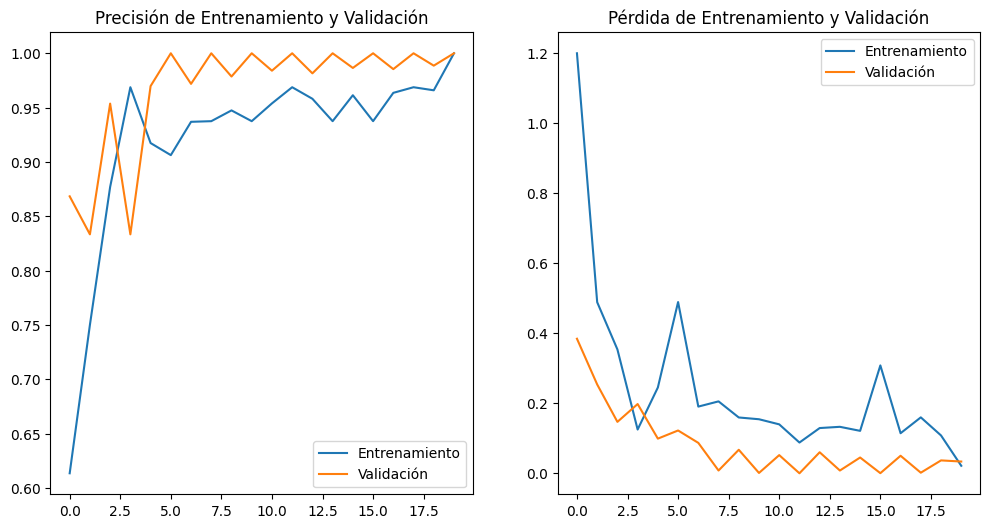

In [ ]:
# Graficar precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')
plt.show()

Lo almacenamos

In [ ]:
model.save('arq_modelo_6.h5')
model.save('arq_modelo_6.keras')

Predicciones

In [ ]:
clases = {'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'Nothing': 14,
 'O': 15,
 'P': 16,
 'Q': 17,
 'R': 18,
 'S': 19,
 'Space': 20,
 'T': 21,
 'U': 22,
 'V': 23,
 'W': 24,
 'X': 25,
 'Y': 26,
 'Z': 27}

In [ ]:
print(clases)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'Nothing': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'Space': 20, 'T': 21, 'U': 22, 'V': 23, 'W': 24, 'X': 25, 'Y': 26, 'Z': 27}


In [ ]:
from tensorflow.keras.models import load_model

# Cargamos el modelo
model = load_model('/content/arq_modelo_6.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


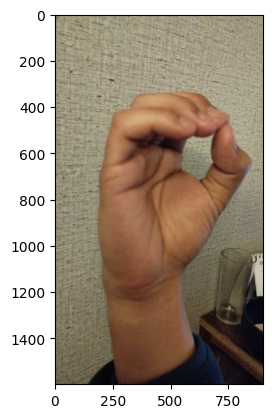

La seña predicha es: Space


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_sign(img_path, model):
    img = image.load_img(img_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalizar
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    # Invertir el diccionario de class_indices
    class_indices = {v: k for k, v in clases.items()}

    # Obtener la clase predicha
    predicted_class_name = class_indices[predicted_class[0]]
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
    return predicted_class_name

# Ejemplo de uso
# Asegúrate de que la ruta a tu imagen sea correcta
sign = predict_sign('/content/prueba_data/o_kevin.jpg', model)
print("La seña predicha es:", sign)